# Practical Five: Optical Flow

This notebook is prepared to introduce you to the basics of estimating and visualising optical flow field (motion) in bi-temporal images. We will use the celebrated Lucas-Kanade method to estimate the optical flow field.

### References
* [Based on "Homework 3: Optical Flow"](https://github.com/pjreddie/vision-hw3)
* [Lecture 8: Optical Flow](https://docs.google.com/presentation/d/11f77YuX5YVUmhr1QWYGCSmg5lHyml0VaRjDh93aceHI/edit?usp=sharing)
* [Lucas–Kanade method](https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method)

## Load Required Modules

In [1]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import numpy as np
import matplotlib.pyplot as pl

In [26]:
def np2img(im, norm=False, rgb_mode=False):
    """
    This function converts the input numpy object im to Image object and returns
    the converted object. If norm == True, then the input is normalised to [0,1]
    using im <- (im - im.min()) / (im.max() - im.min()).
    """
    if norm:
        if ((im.max() - im.min()) != 0.0):
            im = (im - im.min()) / (im.max() - im.min())

    if ((im.min() >= 0.0) and (im.max() <= 1.0)):
        im = im * 255.0

    if rgb_mode and im.ndim == 2:
        im = im[...,np.newaxis].repeat(3, axis=2)
        
    if im.ndim == 2:
        im = Image.fromarray(im.astype(np.uint8), mode='L')
    elif (im.ndim == 3) and (im.shape[2] == 3):
        im = Image.fromarray(im.astype(np.uint8), mode='RGB')

    return im


def imresize_nn(im, width, height, img_obj=False):
    """
    This function resizes the input Image object im to the size of (width x height)
    pixels based on the nearest neigbor interpolation and returns the resized Image object.
    """
    # Convert the input Image object to numpy array object
    im = np.array(im).astype(float)
    if (im.shape[0] == height) and (im.shape[1] == width):
        im_res = im.copy()
    else:
        # Create an empty array of (height x width) pixels
        if im.ndim == 2:
            im_res = np.zeros((height, width))
        else:
            im_res = np.zeros((height, width, im.shape[2]))

        # Match up coordinates using (x_res, y_res) -> (x_im, y_im), i.e.,
        # a_x * x_res + b_x = x_im
        # a_y * y_res + b_y = y_im
        a_x = ((im.shape[1] - 0.5) - (-0.5)) / ((im_res.shape[1] - 0.5) - (-0.5))
        b_x = (-0.5) - a_x * (-0.5)
        a_y = ((im.shape[0] - 0.5) - (-0.5)) / ((im_res.shape[0] - 0.5) - (-0.5))
        b_y = (-0.5) - a_y * (-0.5)

        # Create a lookup table for speeding up the operations
        y_im = np.zeros(im_res.shape[0], dtype=np.int32)
        for i in range(im_res.shape[0]):
            y_im[i] = int(np.round(a_y * i + b_y))
            if y_im[i] < 0:
                y_im[i] = 0
            if y_im[i] > (im.shape[0] - 1):
                y_im[i] = im.shape[0] - 1

        x_im = np.zeros(im_res.shape[1], dtype=np.int32)
        for i in range(im_res.shape[1]):
            x_im[i] = int(np.round(a_x * i + b_x))
            if x_im[i] < 0:
                x_im[i] = 0
            if x_im[i] > (im.shape[1] - 1):
                x_im[i] = im.shape[1] - 1
        # Iterate over new points
        for y in range(im_res.shape[0]):
            for x in range(im_res.shape[1]):
                im_res[y, x] = im[y_im[y], x_im[x]]

    if img_obj:
        im_res = np2img(im_res)

    return im_res


def imresize_bi(im, width, height, img_obj=False):
    """
    This function resizes the input Image object im to the size of (width x height) 
    pixels based on the bilinear interpolation and returns the resized Image object.
    """
    # Convert the input Image object to numpy array object

    im = np.array(im).astype(float)
    if (im.shape[0] == height) and (im.shape[1] == width):
        im_res = im.copy()
    else:
        # Create an empty array of (height x width) pixels
        if im.ndim == 2:
            im_res = np.zeros((height, width))
        else:
            im_res = np.zeros((height, width, im.shape[2]))

        # Match up coordinates using (x_res, y_res) -> (x_im, y_im), i.e.,
        # a_x * x_res + b_x = x_im
        # a_y * y_res + b_y = y_im
        a_x = ((im.shape[1]-0.5) - (-0.5)) / ((im_res.shape[1]-0.5) - (-0.5))
        b_x = (-0.5) - a_x * (-0.5)
        
        a_y = ((im.shape[0]-0.5) - (-0.5)) / ((im_res.shape[0]-0.5) - (-0.5))
        b_y = (-0.5) - a_y * (-0.5)
        
        # Create a lookup table for speeding up the operations
        y_im = np.zeros((im_res.shape[0], 2), dtype=np.int32)
        y_im_d = np.zeros((im_res.shape[0], 2), dtype=np.float32)
        for i in range(im_res.shape[0]):
            y_im_ = a_y * i + b_y
            # Take care of the boundary cases
            if y_im_ < 0.0:
                y_im_ = np.abs(y_im_)
            if y_im_ > (im.shape[0]-1):
                y_im_ = (im.shape[0]-1) - (y_im_-(im.shape[0]-1))
            # Compute the mapping in the input image coordinate
            y_im[i,0] = int(np.floor(y_im_))
            y_im[i,1] = int(np.ceil(y_im_))
            y_im_d[i,0] = y_im[i,1] - y_im_
            y_im_d[i,1] = y_im_ - y_im[i,0]
            

        x_im = np.zeros((im_res.shape[1], 2), dtype=np.int32)
        x_im_d = np.zeros((im_res.shape[1], 2), dtype=np.float32)
        for i in range(im_res.shape[1]):
            x_im_ = a_x * i + b_x
            # Take care of the boundary cases
            if x_im_ < 0.0:
                x_im_ = np.abs(x_im_)
            if x_im_ > (im.shape[1]-1):
                x_im_ = (im.shape[1]-1) - (x_im_-(im.shape[1]-1))
            # Compute the mapping in the input image coordinate
            x_im[i,0] = int(np.floor(x_im_))
            x_im[i,1] = int(np.ceil(x_im_))
            x_im_d[i,0] = x_im[i,1] - x_im_
            x_im_d[i,1] = x_im_ - x_im[i,0]
        
        # Iterate over new points
        for y in range(im_res.shape[0]):
            for x in range(im_res.shape[1]):
                if (x_im[x,0] == x_im[x,1]) and (y_im[y,0] == y_im[y,1]):
                    q = im[y_im[y,0], x_im[x,0]]
                elif (x_im[x,0] == x_im[x,1]):
                    v1 = im[y_im[y,0], x_im[x,0]]
                    v3 = im[y_im[y,1], x_im[x,1]]
                    q = v1 * y_im_d[y,0] + v3 * y_im_d[y,1]
                elif (y_im[y,0] == y_im[y,1]):
                    v1 = im[y_im[y,0], x_im[x,0]]
                    v2 = im[y_im[y,1], x_im[x,1]]
                    q = v1 * x_im_d[x,0] + v2 * x_im_d[x,1]
                else:
                    v1 = im[y_im[y,0], x_im[x,0]]
                    v2 = im[y_im[y,0], x_im[x,1]]
                    v3 = im[y_im[y,1], x_im[x,0]]
                    v4 = im[y_im[y,1], x_im[x,1]]
                    q1 = v1 * x_im_d[x,0] + v2 * x_im_d[x,1]
                    q2 = v3 * x_im_d[x,0] + v4 * x_im_d[x,1]
                    q = q1 * y_im_d[y,0] + q2 * y_im_d[y,1]
    
                im_res[y, x] = q

    if img_obj:
        im_res = np2img(im_res)
    
    return im_res


def imfilter(im, filter, preserve=False, img_obj=False, mode='edge'):
    """
    This function filters the input object im with the numpy array filter and 
    returns the filtered image object.
    """
    # Convert the input object to numpy array object
    im = np.array(im).astype(float)
    if (im.ndim == 2):
        im = im[...,np.newaxis]
    # Get the filter dimensions
    h, w = filter.shape[:2][0] // 2, filter.shape[:2][1] // 2
    if (filter.ndim == 2):
        filter = filter[...,np.newaxis]
    # Apply padding on the input image to handle image boundaries
    pad_width = [[h,h],[w,w]]
    for d in range(2, im.ndim):
        pad_width.append([0,0])
    im = np.pad(im, pad_width=pad_width, mode=mode)
    # Create place holder for the filtered image
    if preserve:
        im_ = im.copy()
        # Iterate over pixels
        for y in range(h, im.shape[0]-h):
            for x in range(w, im.shape[1]-w):
                im_[y,x] = (im[y-h:y+h+1, x-w:x+w+1] * filter).sum(axis=(0,1))
    else:
        im_ = np.zeros(im.shape[:2])
        # Iterate over pixels
        for y in range(h, im.shape[0]-h):
            for x in range(w, im.shape[1]-w):
                im_[y,x] = (im[y-h:y+h+1, x-w:x+w+1] * filter).sum()

    # Exclude the boundary pixels
    im = im_[h:im.shape[0]-h, w:im.shape[1]-w]

    if img_obj:
        im = np2img(im)
    
    return im


def box_filter(width, height, channel=1):
    """
    This function creates and returns a numpy array of size (height x width) with all entries equal to 1/(height x width x channel). 
    If any of input parameters width and height is an even number, then it is rolled up to the nearest
    odd number. Note that if channel > 1, then the returned array will be of dimensions (height x width x channel).
    """
    if (width % 2) == 0:
        width += 1
    if (height % 2) == 0:
        height += 1

    if channel > 1:
        data = np.ones((height, width, channel)) / (height * width * channel)
    else:
        data = np.ones((height, width)) / (height * width)

    return data


def gaussian_kernel(sigma, dim=1):
    """
    This function generates and returns either a 1D (dim=1) or 2D (dim=2)
    Gaussian kernel with a standard deviation sigma. Note that the function
    automatically adjusts the kernel size so that 99% of the distribution falls 
    within 3 standard deviations.
    """
    k = int(2 * np.ceil(3*sigma) + 1)
    x = np.linspace(-3*sigma, 3*sigma, k)
    g = 1.0 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-x**2/(2*sigma**2))
    g = g / g.sum()
    g = g[np.newaxis,...]
    if dim == 2:
        g = np.dot(g.T, g)
        
    return g

## Lucas-Kanade Optical Flow Estimation

We will be implementing [Lucas–Kanade method](https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method) to estimate the optical flow (velocity) vector $(u_{i},v_{i})$ for the pixel $\mathbf{p}_{i} = (x_{i}, y_{i})$ using the following equation

$
\left[\begin{matrix} u_{i} \\ v_{i} \end{matrix}\right]=\left[\begin{matrix} \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{x}(\mathbf{p}_{j}) & \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{y}(\mathbf{p}_{j}) \\ \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{x}(\mathbf{p}_{j}) & \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{y}(\mathbf{p}_{j}) \end{matrix}\right]^{-1} \left[\begin{matrix} -\sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{t}(\mathbf{p}_{j}) \\ -\sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{t}(\mathbf{p}_{j}) \end{matrix}\right],
$

where $u_{i}$ and $v_{i}$ are respectively estimated horizontal and vertical velocity at the pixel $\mathbf{p}_{i}$, $\mathcal{N}_{i}$ represents the set of all pixels within the neighborhood of the pixel $\mathbf{p}_{i}$. $I_{x}(\mathbf{p}_{i})$, $I_{y}(\mathbf{p}_{i})$, $I_{t}(\mathbf{p}_{i})$ are the partial derivatives of the image $I$ with respect to position $x$, $y$ and time $t$, evaluated at the pixel $\mathbf{p}_{i}$ and at the current time. $\mathcal{N}_{i}$ is usually based on a $w \times w$ window around the pixel $\mathbf{p}_{i}$. 



### Estimating Spatial and Temporal Derivatives

In order to compute the optical flow (velocity) vector $(u_{i},v_{i})$ for the pixel $\mathbf{p}_{i}$, we first need to compute the partial derivatives $I_{x}(\mathbf{p}_{i})$, $I_{y}(\mathbf{p}_{i})$, $I_{t}(\mathbf{p}_{i})$ at the pixel $\mathbf{p}_{i}$. We already know how to compute spatial derivatives $I_{x}$ and $I_{y}$ from the previous practicals. The partial derivative of the image $I$ with respect to time $t$ (or temporal derivative of the image) can be computed as follows

$I_{t} = I^{(t)} - I^{(t-1)}$,

where $I^{(t)}$ is the current image at time $t$ (i.e., $I^{(t)} = I$) and $I^{(t-1)}$ is the previous image at time $(t-1)$. Please note that we slightly abuse the mathematical notation here by introducing the superscript $(t)$ to represent the images captured in time.

In the following, we load and display two consecuitive images `I1` and `I2`, where `I2` is the most recent image, i.e., $I^{(t)}$=`I2` and $I^{(t-1)}$=`I1`.

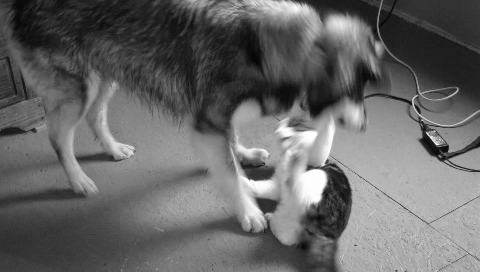

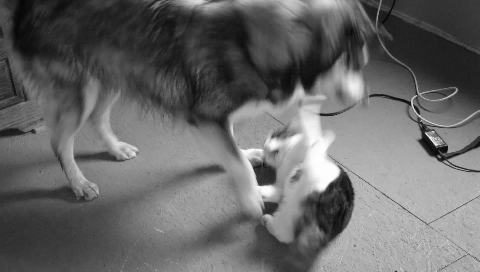

In [3]:
I1_RGB = Image.open('../data/dog_time1.jpg').convert('RGB')
I2_RGB = Image.open('../data/dog_time2.jpg').convert('RGB')
I3_RGB = Image.open('../data/dog_time3.jpg').convert('RGB')
I1_RGB = imresize_nn(I1_RGB, I1_RGB.width//4, I1_RGB.height//4, True)
I2_RGB = imresize_nn(I2_RGB, I2_RGB.width//4, I2_RGB.height//4, True)
I3_RGB = imresize_nn(I3_RGB, I3_RGB.width//4, I3_RGB.height//4, True)


F = np.array([[[0.299, 0.587, 0.114]]])
I1 = imfilter(I1_RGB, F) / 255.0
I2 = imfilter(I2_RGB, F) / 255.0

display(np2img(I1))
display(np2img(I2))

As we did before, we first need to blur the input images before computing spatial and temporal derivatives.

In [4]:
# Set the kernels
G = gaussian_kernel(sigma=1.0, dim=2)
Sx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
Sy = Sx.copy().T
# Blur the current and previous images using a Gaussian kernel
I1 = imfilter(I1, G)
I2 = imfilter(I2, G)
# Calculate the spatial derivatives of the current image
Ix = imfilter(I2, Sx)
Iy = imfilter(I2, Sy)
# Calculate the temporal derivative of the current image
It = (I2-I1)

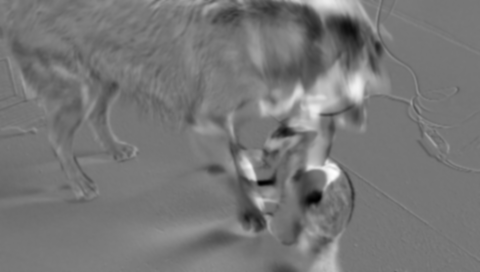

In [6]:
display(np2img(It, norm=True))

The temporal derivative image `It = (I2 - I1)` is normalised to the range of [0,1] to highlight the high-motion pixels. The high-motion pixels are displayed in either very dark or very bright tones on the temporal derivative image.

### Computing the Velocity Vector

In order to compute the velocity vector $(u_{i},v_{i})$, we need to perform the following matrix operations

$
\left[\begin{matrix} u_{i} \\ v_{i} \end{matrix}\right] = \left[\begin{matrix} \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{x}(\mathbf{p}_{j}) & \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{y}(\mathbf{p}_{j}) \\ \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{x}(\mathbf{p}_{j}) & \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{y}(\mathbf{p}_{j}) \end{matrix}\right]^{-1} \left[\begin{matrix} -\sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{t}(\mathbf{p}_{j}) \\ -\sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{t}(\mathbf{p}_{j}) \end{matrix}\right],
$

which requires computing the inverse of the $2 \times 2$ structure matrix. The inverse exists if and only if the determinant of the structure matrix is not equal to zero. Suppose that the inverse exits. Then we can compute the velocity vector $(u_{i},v_{i})$ as follows

$
u_{i} = \frac{-\sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{y}(\mathbf{p}_{j}) \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{t}(\mathbf{p}_{j}) +
\sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{y}(\mathbf{p}_{j}) \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{t}(\mathbf{p}_{j})}
{\sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{x}(\mathbf{p}_{j}) \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{y}(\mathbf{p}_{j}) -
\sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{y}(\mathbf{p}_{j}) \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{x}(\mathbf{p}_{j})}
$

and

$
v_{i} = \frac{\sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{t}(\mathbf{p}_{j}) \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{y}(\mathbf{p}_{j}) -
\sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{x}(\mathbf{p}_{j}) \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{t}(\mathbf{p}_{j})}
{\sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{x}(\mathbf{p}_{j}) \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{y}(\mathbf{p}_{j}) -
\sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{x}(\mathbf{p}_{j}) I_{y}(\mathbf{p}_{j}) \sum\limits_{\mathbf{p}_{j} \in \mathcal{N}_{i}} I_{y}(\mathbf{p}_{j}) I_{x}(\mathbf{p}_{j})}.
$

We can implement these operations as follows.

In [7]:
def compute_flow(I1_RGB, I2_RGB, sigma=1.0, w=3, epsilon=1e-8):
    """
    Computes and returns optical flow vector.
    """
    F = np.array([[[0.299, 0.587, 0.114]]])
    I1 = imfilter(I1_RGB, F) / 255.0
    I2 = imfilter(I2_RGB, F) / 255.0
    # Set the kernels
    G = gaussian_kernel(sigma=sigma, dim=2)
    Sx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
    Sy = Sx.copy().T
    # Blur the current and previous images using a Gaussian kernel
    I1 = imfilter(I1, G)
    I2 = imfilter(I2, G)
    # Calculate the spatial derivatives of the current image
    Ix = imfilter(I2, Sx)
    Iy = imfilter(I2, Sy)
    # Calculate the temporal derivative of the current image
    It = (I2-I1)
    
    B = box_filter(w, w)
    IxIx = imfilter(Ix*Ix, B)
    IxIy = imfilter(Ix*Iy, B)
    IyIy = imfilter(Iy*Iy, B)
    IxIt = imfilter(Ix*It, B)
    IyIt = imfilter(Iy*It, B)

    d = IxIx * IyIy - IxIy * IxIy
    u = np.zeros_like(d)
    v = np.zeros_like(d)
    index = (d>=epsilon)
    u[index] = (- IyIy[index] * IxIt[index] + IxIy[index] * IyIt[index]) / d[index]
    v[index] = (IxIt[index] * IxIy[index] - IxIx[index] * IyIt[index]) / d[index]
    
    return u, v

In [8]:
def draw_flow(im, u, v, delta=1.0, w=7, s=2, fill=(255,0,0), width=1):
    """
    This function draws the velocity field (u,v) on the input image im using
    w x w blocks with field scaling factors s.
    """
    im_flow = im.copy()
    draw = ImageDraw.Draw(im_flow)
    B = box_filter(w,w)
    
    u = imfilter(u, B)
    v = imfilter(v, B)
    
    uv = np.sqrt(u**2 + v**2)
    u[u<=delta] = 0.0
    v[v<=delta] = 0.0
    
    u *= s
    v *= s
    
    uv_max = w // 2
    uv_min = -uv_max
    
    u[u>=uv_max] = uv_max
    u[u<=uv_min] = uv_min
    
    v[v>=uv_max] = uv_max
    v[v<=uv_min] = uv_min
    
    for y in range(w//2, u.shape[0], w):
        for x in range(w//2, u.shape[1], w):
            draw.line((x,y) + (x+u[y,x],y+v[y,x]), fill=fill, width=width)
            
    return im_flow

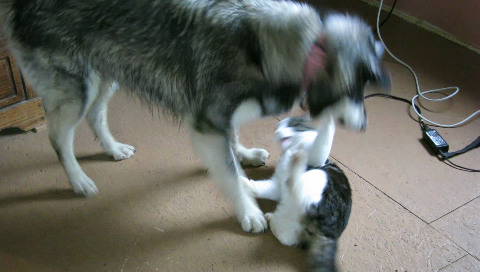

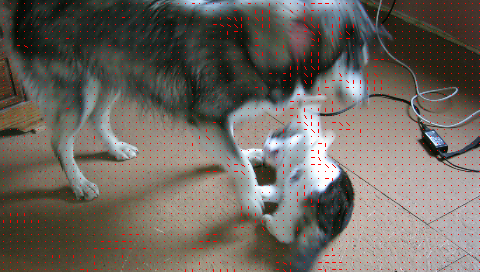

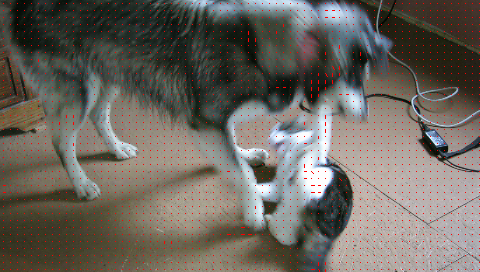

In [9]:
u,v =  compute_flow(I1_RGB, I2_RGB, w=7)
I2_RGB_flow = draw_flow(I2_RGB, u, v)
u,v =  compute_flow(I2_RGB, I3_RGB, w=7)
I3_RGB_flow = draw_flow(I3_RGB, u, v)

display(I1_RGB)
display(I2_RGB_flow)
display(I3_RGB_flow)

### Your Task [40 Marks]

By changing the parameters `sigma` and `w` of the function `compute_flow(...)`, analyse the impact of change in parameter values on the estimated velocity vector and provide a short report here. Support your discussion with experimental results on another image sequence you can find online or create yourself.

#### Short report of experiments with `sigma` and `w`

**sigma experiments**

By inspecting the code of  `compute_flow(...)`, it become clear that the sigma parameter is used in the gaussian kernel for blurring the input images. The goal of the bluring is to reduce noise and local variations whithin the images. In order to see the impact of changes in the sigma parameter, I have calculated the average flow-vector magnitude of different sigma values ranging from 1 to 15 with a step value of 0.5. I use the average magnitude as a measurement on how good the algorithm is at picking up details.

![Flow-vector magnitude with different sigma values](../figs/sigma_chart.png)

As shown in the graph, the average magnitude of the flow vectors decrease as the sigma value is increased, indicating increasing loss of details within the image as a result of increased blurring of the image features. In order to visualise the loss of details, I have computed the flow using `sigma = 4.0` and ``sigma = 14.0` and visualized the results in a heatmap. The selected sigma values corresponds to the top and bottom values from the previous plot.

![Flow-vector magnitude with different sigma values](../figs/sigma_heat.png)

As seen in the heatmap, a high sigma value causes small details to be skipped.


**w experiments**

The `w` parameter denotes the size (width and height) of the box filter used to smoothen the images in `compute_flow(...)`. To analyse the impact of changes in the `w` parameter, i used a similar approach as in the sigma experiments.

![Flow-vector magnitude with different w values](../figs/w_chart.png)

By looking at the graph, the average flow magnitude decreases as the w value increases after a given value. Similarly as with the sigma parameter, when plotting the results in a heatmap one can se that a lot of local details is lost.

![Flow-vector magnitude with different w values](../figs/w_heat.png)

In [ ]:
# Experiment with different values of w

# Try different values of sigma between 0.5 and 2.0 with a step of 0.25
w_range = np.arange(1, 25, 1).astype(int)

# Calculate the average flow magnitude for different values of sigma
avg_flow_mag = []

for w in w_range:
    u, v = compute_flow(I1_RGB, I2_RGB, w=w)
    a = np.mean(np.sqrt(u**2 + v**2))
    avg_flow_mag.append(a)

# Plot the average flow magnitude for different values of sigma
pl.plot(w_range, avg_flow_mag, marker='o')
pl.xlabel('w')
pl.ylabel('Average Flow Magnitude')
pl.title('Average Flow Magnitude vs w')
pl.grid()
pl.show()

In [ ]:
# Heatmap of flow vectors (w)

# Try sigma = 4 and sigma = 14
w_range = [3, 24]

fig, ax = pl.subplots(1, 2, figsize=(10, 10))

for i, w in enumerate(w_range):
    u, v = compute_flow(I1_RGB, I2_RGB, w=w)
    mag = np.sqrt(u**2 + v**2)
    
    ax[i].imshow(mag, cmap='hot')
    ax[i].set_title('Sigma: {:.0f}'.format(w))
    ax[i].axis('off')

pl.show()

In [ ]:
# Experiment with different values of sigma

# Try different values of sigma between 0.5 and 2.0 with a step of 0.25
sigma_range = np.arange(1, 15, 0.5)

# Calculate the average flow magnitude for different values of sigma
avg_flow_mag = []

for sigma in sigma_range:
    u, v = compute_flow(I1_RGB, I2_RGB, sigma=sigma, w=7)
    a = np.mean(np.sqrt(u**2 + v**2))
    avg_flow_mag.append(a)

# Plot the average flow magnitude for different values of sigma
pl.plot(sigma_range, avg_flow_mag, marker='o')
pl.xlabel('Sigma')
pl.ylabel('Average Flow Magnitude')
pl.title('Average Flow Magnitude vs Sigma')
pl.grid()
pl.show()

In [ ]:
# Heatmap of flow vectors

# Try sigma = 4 and sigma = 14
sigma_range = [4, 14]

fig, ax = pl.subplots(1, 2, figsize=(10, 10))

for i, sigma in enumerate(sigma_range):
    u, v = compute_flow(I1_RGB, I2_RGB, sigma=sigma, w=7)
    mag = np.sqrt(u**2 + v**2)
    
    ax[i].imshow(mag, cmap='hot')
    ax[i].set_title('Sigma: {:.2f}'.format(sigma))
    ax[i].axis('off')

pl.show()

### Your Task [40 Marks]

Lucas–Kanade method fails if the motion is large. Find two image sequences for failure and success cases of the Lucas–Kanade method and demonstrate the performance of the Lucas–Kanade method on those image sequences. You can also create your own image sequences. However, you must place those image sequences under the `data` folder.

#### Lucas-Kanade method experiments

I have recorded two movies of a Red-Bull can that is dropped/moved with different velocities. In the `red_bull_1.MOV` the can is moved fast and the movie only has a couple of frames that captures the can as it moves. In the `red_bull_2.MOV` file, the can is moved slowly and the motion is captured in multiple frames with a small amount of movement in each frame.

In the two images below, the visualized motion field is all over the place, and the Lucas-Kanade method fails to detect that the motion of the can is towards the bottom om the image. 

![red_bull_2.MOV frame A](../figs/mov1_frame_a.png)
![red_bull_2.MOV frame A](../figs/mov1_frame_b.png)


In the two images below, the motion field is detected and visualized correctly as the can is moving towards the bottom of the image.

![red_bull_2.MOV frame A](../figs/mov2_frame_a.png)
![red_bull_2.MOV frame A](../figs/mov2_frame_b.png)



In [43]:
# Split mov video file into frames
import cv2

# Open the video file
mov = cv2.VideoCapture('../data/mov2/red_bull_2.MOV')

# Read the video file
frames = []

while True:
    ret, frame = mov.read()
    if not ret:
        break
    frames.append(frame)

# Save the frames as images
for i, frame in enumerate(frames):
    cv2.imwrite('../data/mov2/frames/frame_{:04d}.jpg'.format(i), frame)

# Close the video file
mov.release()


In [ ]:
# Visualize the images

I1_RGB = Image.open('../data/mov2/frames/frame_0060.jpg').convert('RGB')
I2_RGB = Image.open('../data/mov2/frames/frame_0061.jpg').convert('RGB')
I3_RGB = Image.open('../data/mov2/frames/frame_0062.jpg').convert('RGB')
I1_RGB = imresize_nn(I1_RGB, I1_RGB.width//4, I1_RGB.height//4, True)
I2_RGB = imresize_nn(I2_RGB, I2_RGB.width//4, I2_RGB.height//4, True)
I3_RGB = imresize_nn(I3_RGB, I3_RGB.width//4, I3_RGB.height//4, True)

u,v =  compute_flow(I1_RGB, I2_RGB, w=7)
I2_RGB_flow = draw_flow(I2_RGB, u, v)
u,v =  compute_flow(I2_RGB, I3_RGB, w=7)
I3_RGB_flow = draw_flow(I3_RGB, u, v)

display(I1_RGB)
display(I2_RGB_flow)
display(I3_RGB_flow)

In [41]:
# Split mov video file into frames
import cv2

# Open the video file
mov = cv2.VideoCapture('../data/mov1/red_bull_1.MOV')

# Read the video file
frames = []

while True:
    ret, frame = mov.read()
    if not ret:
        break
    frames.append(frame)

# Save the frames as images
for i, frame in enumerate(frames):
    cv2.imwrite('../data/mov1/frames/frame_{:04d}.jpg'.format(i), frame)

# Close the video file
mov.release()


In [ ]:
# Visualize the images

I1_RGB = Image.open('../data/mov1/frames/frame_0030.jpg').convert('RGB')
I2_RGB = Image.open('../data/mov1/frames/frame_0031.jpg').convert('RGB')
I3_RGB = Image.open('../data/mov1/frames/frame_0032.jpg').convert('RGB')
I1_RGB = imresize_nn(I1_RGB, I1_RGB.width//4, I1_RGB.height//4, True)
I2_RGB = imresize_nn(I2_RGB, I2_RGB.width//4, I2_RGB.height//4, True)
I3_RGB = imresize_nn(I3_RGB, I3_RGB.width//4, I3_RGB.height//4, True)

u,v =  compute_flow(I1_RGB, I2_RGB, w=7)
I2_RGB_flow = draw_flow(I2_RGB, u, v)
u,v =  compute_flow(I2_RGB, I3_RGB, w=7)
I3_RGB_flow = draw_flow(I3_RGB, u, v)

display(I1_RGB)
display(I2_RGB_flow)
display(I3_RGB_flow)

### Your Task [20 Marks]

The Lucas-Kanade method fails if the motion is large. How can you improve the Lucas-Kanade method to handle large motions? Justify your answer with experiments and evidence from the literature.

There are several different solution to solving this issue with the Lucas-Kanade method. 

[1] and [3] Describes how to implement a pyramidal-based implementation of the Locas-Kanade method. By utilizing image pyramids it allows for handle changes in scale between images. This method is more robost for large motions as it starts feature tracking low in the pyramid and gradually tracks finer and finer details.

[2] proposes a solution that uses a confidence-predictor to detect false features. The goal is to improve the accuracy by preventing errors from propegating by detecting false features early on (and dismiss them).


**Sources**

[1] Bouguet, J. Y. (2001). Pyramidal implementation of the affine lucas kanade feature tracker description of the algorithm. Intel corporation, 5(1-10), 4.

[2] Y. Niu, Z. Xu and X. Che, "Dynamically Removing False Features in Pyramidal Lucas-Kanade Registration," in IEEE Transactions on Image Processing, vol. 23, no. 8, pp. 3535-3544, Aug. 2014, doi: 10.1109/TIP.2014.2331140.

[3] [Biswas, D. (2021, Jun 27). Lucas-Kanade Method for Optical Flow. Medium.](https://dibyendu-biswas.medium.com/lucas-kanade-method-for-optical-flow-87ea48dd3e69)
